In [4]:
import pandas as pd
import numpy as np
import pickle as pkl
import scipy.stats as stats
import os, re, fnmatch
import pathlib, itertools, time
import matplotlib.pyplot as plt
import joblib
import random

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import explained_variance_score
from sklearn import metrics
from sklearn.linear_model import ElasticNet, Lasso, LinearRegression, Ridge
from matplotlib import cm
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Default figure parameters
plt.rcParams['figure.figsize'] = (8,5)
plt.rcParams['font.size'] = 12
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14

%matplotlib inline

NAME: __TODO: Vignesh Murugan

# Machine Learning Practice - Live
## Homework 07: Model Comparisons
 
## Assignment Overview
Read through the entire notebook and do not write any code. This assignment
is more complex than previous ones, and it will be helpful to have a sense of 
the structure before you start coding.  


### Task
For this assignment, you will be comparing different models after performing holistic cross validation to find the best parameter sets for various sizes of the training data. 

Specifically, we will be experimenting with 3 different model types:
1. LinearRegression (this is just a 2D experiment since there are no hyperparameters)
2. Ridge
3. Lasso

Once a hyper-parameter set is chosen for these models, we will compare the test set performance across each pair of models.  Remember -- you should only look at test set performance late in any evaluation process.


### Data set
The dataset is identical to what we used in HW06

### Objectives
* Use and understand __Holistic Cross Validation__
* Understand how training set size affects model choices
* Learn to perform model selection using hypothesis testing

### Instructions
* All Homework must be individual work.  Do not look at or copy solutions of other students or that are available on the Internet or via LLMs
* Only work in a copy of the file that is from your ~/homework_in/ directory
   + If you do not use your own copy of this file, then it is an automatic zero on the assignment
* Read the code below 
* For any cell that is flagged as *TODO*, complete the code according to the specifications
* Execute each cell and verify that it is showing correct results.  Note that because we are reusing variables, the order of execution is *really* important (you should code assuming top to bottom execution).
* All the plotting functions have been provided. You should not need to alter any of these.
* Hand-In Procedure
  + Make sure that your notebook has been saved.  You are responsible for ensuring that the copy that you submit is current and complete
  + The name of the file should be the same as what we gave you
  + Download this file to your local machine (extension: .ipynb)
  + Submit to the Gradescope Notebook HW07 dropbox


### General References
* [Guide to Jupyter](https://www.datacamp.com/community/tutorials/tutorial-jupyter-notebook)
* [Python Built-in Functions](https://docs.python.org/3/library/functions.html)
* [Python Data Structures](https://docs.python.org/3/tutorial/datastructures.html)
* [Numpy Reference](https://docs.scipy.org/doc/numpy/reference/index.html)
* [Numpy Cheat Sheet](https://s3.amazonaws.com/assets.datacamp.com/blog_assets/Numpy_Python_Cheat_Sheet.pdf)
* [Summary of matplotlib](https://matplotlib.org/3.1.1/api/pyplot_summary.html)
* [DataCamp: Matplotlib](https://www.datacamp.com/community/tutorials/matplotlib-tutorial-python?utm_source=adwords_ppc&utm_campaignid=1565261270&utm_adgroupid=67750485268&utm_device=c&utm_keyword=&utm_matchtype=b&utm_network=g&utm_adpostion=1t1&utm_creative=332661264365&utm_targetid=aud-299261629574:dsa-473406587955&utm_loc_interest_ms=&utm_loc_physical_ms=9026223&gclid=CjwKCAjw_uDsBRAMEiwAaFiHa8xhgCsO9wVcuZPGjAyVGTitb_-fxYtkBLkQ4E_GjSCZFVCqYCGkphoCjucQAvD_BwE)
* [Pandas DataFrames](https://urldefense.proofpoint.com/v2/url?u=https-3A__pandas.pydata.org_pandas-2Ddocs_stable_reference_api_pandas.DataFrame.html&d=DwMD-g&c=qKdtBuuu6dQK9MsRUVJ2DPXW6oayO8fu4TfEHS8sGNk&r=9ngmsG8rSmDSS-O0b_V0gP-nN_33Vr52qbY3KXuDY5k&m=mcOOc8D0knaNNmmnTEo_F_WmT4j6_nUSL_yoPmGlLWQ&s=h7hQjqucR7tZyfZXxnoy3iitIr32YlrqiFyPATkW3lw&e=)
* [Sci-kit Learn Linear Models](https://scikit-learn.org/stable/api/sklearn.linear_model.html)
* [Sci-kit Learn Model Selection](https://scikit-learn.org/stable/api/sklearn.model_selection.html)
* [Sci-kit Learn Ensemble Models](https://scikit-learn.org/stable/api/sklearn.ensemble.html)
* [Sci-kit Learn Metrics](https://scikit-learn.org/stable/api/sklearn.metrics.html)
* [JobLib](https://joblib.readthedocs.io/en/latest/)
* [Student's t-test](https://en.wikipedia.org/wiki/Student%27s_t-test#Dependent_t-test_for_paired_samples)
* [Understanding Paired t-tests](https://machinelearningmastery.com/how-to-code-the-students-t-test-from-scratch-in-python/)
* [Two-tailed Tests](https://www.investopedia.com/terms/t/two-tailed-test.asp)
* [SciPy Paired t-test for Dependent Samples](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_rel.html)

# LOAD DATA

In [5]:
""" PROVIDED
Load the BMI data from all the folds
"""
fname = '/mlp/datasets/bmi/bmi_dataset.pkl'

with open(fname, 'rb') as f:
    bmi = pkl.load(f)

    MI_folds = bmi['MI'] 
    theta_folds = bmi['theta']
    dtheta_folds = bmi['dtheta']
    ddtheta_folds = bmi['ddtheta']
    torque_folds = bmi['torque']
    time_folds = bmi['time']


nfolds = len(MI_folds)
nfolds

20

In [6]:
""" PROVIDED: EXECUTE CELL (same as HWG)
For this homework, we will be generating many different data sets to 
train/validate/test many different models. It is rather problematic to 
to work with individual folds of different length, because numpy 
cannot efficiently concatenate them together  

Here, we construct a single unified array for each of our data types.  folds_idx
is a list (1) of lists (2).  List (1) contains one element for each fold; list (2) 
for a given fold is a list of indices in the in the unified array for *that* fold.
This allows us to efficiently index into our data instead of creating a copy of it each time we want to 
change the size of the training set or our cross-validation rotation.
"""

# Starting index for each fold
folds_idx = [None]*nfolds

unified_idx = 0
for i, fold in enumerate(time_folds):
    # creates a list containing indexes from start of fold to end of fold,
    # eg folds_idx[0] = [0,1,...,1192], folds_idx[1] = [1193,...,2296], ...
    # we don't need to store all this (could just store start indices),
    # but this makes it a lot easier later
    folds_idx[i] = list(range(unified_idx, unified_idx + fold.shape[0]))
    unified_idx += fold.shape[0]

def concat_folds(folds):
    return np.concatenate(folds, axis=0)

# These variables contain *ALL* of the data
MI = concat_folds(MI_folds) 
theta = concat_folds(theta_folds)
dtheta = concat_folds(dtheta_folds)
ddtheta = concat_folds(ddtheta_folds)
torque = concat_folds(torque_folds)
time = concat_folds(time_folds)

# Sizes of the entire data set
print(MI.shape, theta.shape, dtheta.shape, ddtheta.shape, torque.shape, time.shape)

# Starting index of each fold in the full data set
[folds_idx[i][0] for i in range(nfolds)]

(26276, 960) (26276, 2) (26276, 2) (26276, 2) (26276, 2) (26276, 1)


[0,
 1193,
 2297,
 3828,
 5093,
 6591,
 7843,
 9218,
 10348,
 11595,
 12852,
 14117,
 15263,
 16488,
 17726,
 19296,
 20655,
 22234,
 23598,
 24987]

In [7]:
# TODO
# Pass all of the MI data through the StandardScalar now.  
#  We would generally not do this (StandardScaler should be trained
#  only with training data), but this will save a lot of compute time
#  given that we are otherwise repeating this process many times

scaler = StandardScaler()
MI_clean = scaler.fit_transform(MI)  # Standardize the MI data

# Verify the scaling
print(f"Mean of standardized MI: {np.mean(MI_clean):.2f}")
print(f"Standard deviation of standardized MI: {np.std(MI_clean):.2f}")

Mean of standardized MI: 0.00
Standard deviation of standardized MI: 1.00


# PARAMETER SET LIST

In [8]:
""" PROVIDED: EXECUTE CELL (same as HW06)

Construct the Cartesian product of the provided hyper-parameters (a Cartesian
product of two sets is all possible combinations of elements drawn from each set).

Note that one can also include hyper-parameters in the list with only a single
option.  This has the effect of simply setting the same hyper-parameter value for each
of resulting hyper-parameter sets.

"""
def generate_paramsets(param_lists):
    '''
    Construct the Cartesian product of the parameters
    PARAMS:
        params_lists: dict of lists of values to try for each parameter.
                      keys of the dict are the names of the hyper-parameters.
                      values are lists of possible values to try for the 
                      corresponding hyper-parameter
    RETURNS: a list of dicts of hyper-parameter sets.  These make up the 
    Cartesian product of the possible hyper-parameters
    '''
    keys, values = zip(*param_lists.items())
    
    # Determines Cartesian product of parameter values
    combos = itertools.product(*values)
    
    # Constructs list of dictionaries
    combos_dicts = [dict(zip(keys, vals)) for vals in combos]
    return list(combos_dicts)

# PERFORMANCE EVALUTION
Tools for evaluating models

In [9]:
""" PROVIDED (same as HW06)
Evaluate the performance of an already trained model

"""

def predict_score_eval(model, X, y, convert_deg=False):
    '''
    
    Compute the model predictions and cooresponding scores.
    PARAMS:
        model: the trained model used to make predicitons
        X: feature data (MxN)
        y: desired output (Mxk)
        convert_deg: Boolean flag to indicate whether rmse should be
            converted from rad to deg
            
    RETURNS:
        mse: mean squared error for each column (k vector)
        rmse: rMSE (k vector)
        fvaf: fraction of variance accounted for metric (k vector)
        preds: predictions made by the model (M x k matrix)
    '''
    # use the model to predict the outputs from the input data
    preds = model.predict(X) 
    

    # Compute VAR/MSE/RMSE
    mse = np.sum(np.square(y - preds), axis=0) / y.shape[0] 
    var = np.var(y, axis=0)

    fvaf = 1 - mse/var 
    
    rmse = np.sqrt(mse) 
    
    if convert_deg:
        rmse = rmse * 180 / np.pi 

    results = {
        'mse'  : np.reshape(mse,  (1, -1)), 
        'rmse' : np.reshape(rmse, (1, -1)), 
        'fvaf' : np.reshape(fvaf, (1, -1)),  # Fraction of Variance Accounted For
    }
    
    return results



# KFoldHolisticCrossValidation


In [10]:
# TODO: Copy your KFoldHolisticCrossValidation from previous assignment

'''
TODO: Complete K-Fold Cross-Validation implementation

'''
class KFoldHolisticCrossValidation():
    '''
    Cross-validation class. This class will perform cross-validation across for a 
    single hyper-parameter set.
    '''
    def __init__(self, model, eval_func, rotation_skip=1):
        '''
        :param model: The Scikit-Learn model to be trained
        :param eval_func': Python function that will be used to evaluate a model
                                parameters: (inputs, desired outputs, model predictions)
        :param rotation_skip: Number of CV rotations for every one rotation that is actually trained & evaluated.  
                                Typical is 1 (train and evaluate all rotations), but when we are 
                                debugging, it is helpful to perform a smaller number of train/evaluate
                                cycles.
        '''
        self.model = model
        self.eval_func = eval_func
        self.rotation_skip = rotation_skip

    def perform_cross_validation(self, X, y, folds_idx, trainsize):
        ''' TODO      
        
        Documentation is given above
        '''
        
        # Verify that a valid train set size was provided
        nfolds = len(folds_idx)
        if trainsize > nfolds - 2: 
            err_msg = "ERROR: KFoldHolisticCrossValidation.perform_cross_validation() - "
            err_msg += "trainsize (%d) cant be more than nfolds (%d) - 2" % (trainsize, nfolds)
            raise ValueError(err_msg)
        
        # Set up results data structures for each rotation
        results = {'train': None, 'val': None, 'test': None}
        summary = {'train': {}, 'val': {}, 'test': {}}
        
        model = self.model
        evaluate = self.eval_func
        
        # Proceed through the different data rotations
        for rotation in range(0, nfolds, self.rotation_skip):
            (
                Xtrain, ytrain, Xval, yval,  Xtest, ytest
            ) = self.get_data(X, y, folds_idx, nfolds, rotation, trainsize)

            print('Rotation:', rotation, '; train examples:', ytrain.shape)
            
            # TODO: Train model using the training set
            model.fit(Xtrain, ytrain)

            # TODO: Evaluate the model for each data set
            res_train = evaluate(model, Xtrain, ytrain)
            res_val = evaluate(model, Xval, yval)
            res_test = evaluate(model, Xtest, ytest)

            # Record the train, val, and test set results. These are dicts 
            # of result metrics, returned by the evaluate function

            if results['train'] is None: 
                # First rotation: initialize structures
                results['train'] = res_train
                results['val'] = res_val
                results['test'] = res_test
            else:
                # Other rotations: add results to existing structures
                for metric in res_train.keys():
                    results['train'][metric] = np.append(results['train'][metric], res_train[metric], axis=0)
                    results['val'][metric] = np.append(results['val'][metric], res_val[metric], axis=0)
                    results['test'][metric] = np.append(results['test'][metric], res_test[metric], axis=0)

        # Compute/record mean and standard deviation for the size for each metric
        #  The mean is across the rotations
        for metric in results['train'].keys():
            for stat_set in ['train', 'val', 'test']:
                summary[stat_set][metric+'_mean'] = np.mean(results[stat_set][metric], 
                                                            axis=0).reshape(1, -1)
                summary[stat_set][metric+'_std'] = np.std(results[stat_set][metric], 
                                                          axis=0).reshape(1, -1)

        return results, summary

    def get_data(self, X, y, folds_idx, nfolds, rotation, trainsize):
        '''TODO
        
        '''
        # Determine folds to use 
        # (eg fold 1,2,3 for trainsize=3, rotation=1, nfolds=20)
        trainfolds = (np.arange(trainsize) + rotation) % nfolds
        # Single fold for validation
        valfold = (nfolds - 2 + rotation) % nfolds
        # Single fold for testing
        testfold = (valfold + 1) % nfolds
        
        # Construct a list to serve as an index into X for our training
        # samples. This will contain the index of each sample the training set
        train_idx = []
        for i in trainfolds:
            # the + operator concatenates raw python lists
            train_idx += folds_idx[i] 

        # TODO: Construct train set by indexing into X and y with the indices of the
        #  samples that belong to the training set
        Xtrain = X[train_idx]
        ytrain = y[train_idx]
        
        # TODO: Construct validation set using the valfold (a single fold!)
        #       Hint: this is always one fold
        val_idx = folds_idx[valfold] 
        Xval = X[val_idx]
        yval = y[val_idx]

        # TODO: Construct test set using the testfold (a single fold!)
        test_idx = folds_idx[testfold]
        Xtest = X[test_idx]
        ytest = y[test_idx]
        
        return Xtrain, ytrain, Xval, yval, Xtest, ytest


# CrossValidationGridSearch

TODO: Copy in your implementation from the previous HW assignment

In [11]:
# CrossValidationGridSearch

class CrossValidationGridSearch():
    '''
    This class is responsible for performing a grid trainsizes x paramsets CV experiments.
    For each grid point, N-fold crossvalidation is performed (with potential skips in the
    possible rotations).
    
    '''
    def __init__(self, model, paramsets, eval_func, opt_metric, 
                 maximize_opt_metric=False, trainsizes=[1], rotation_skip=1,
                 submodel_name=None
                ):
        ''' TODO
        Class instance constructor
        
        :param model: Model to be trained
        :param paramsets: List of dicts.  Every dict contains a set of hyper-parameters for use in
                            one experiment
        :param eval_func: Python function that will be used to evaluate a model
                                parameters: (inputs, desired outputs, model predictions)
        :param opt_metric: Optimization metric to be used.  Must be included in the 
                          list of metrics returned by eval_func
        :param maximize_opt_metric: True -> best model has high value for performance metric; 
                                    False -> best model has low value
        :param trainsizes: A list of training set sizes (in terms of number of folds)
        :param rotation_skip: Number of CV rotations for every one rotation to train & evaluate.  
                                Typical is 1 (train and evaluate all rotations), but when we are 
                                debugging, it is helpful to perform a smaller number of train/evaluate
                                cycles
        :param submodel_name: If the model is a pipeline, then this is the name of the pipeline
                                component that will make use of the hyper-parameters
        '''
        self.model = model
        self.paramsets = paramsets 
        self.trainsizes = trainsizes 
        self.eval_func = eval_func
        self.opt_metric = opt_metric + '_mean' 
        self.maximize_opt_metric = maximize_opt_metric 
        self.rotation_skip = rotation_skip 
        self.submodel_name = submodel_name
        
        # Results attributes
        # Full recording of all results for all paramsets, sizes, rotations,
        # and metrics. This is a list of dictionaries for each paramset
        self.results = []
        self.results_partial = {}
        # Validation summary report of all means and standard deviations for 
        # all metrics, for all paramsets, and sizes. This is a 3D s x r x p 
        # numpy array. Where s is the number of training set sizes, r the number of summary 
        # metrics +2, and p is the number of hyper-parameter sets
        self.report_by_size = None
        # List of the indices of the best paramset for each size
        self.best_param_inds = None
        self.id = random.randint(0,10000001)

    def load_checkpoint(self, fname):
        ''' PROVIDED
        Load a checkpoint file into self.results
        
        :param fname: Full name of the file to load the checkpoint from. 
        '''
        if not os.path.exists(fname):
            raise ValueError('File %s does not exist'%fname)
        
        with open(fname, 'rb') as f:
            self.results = pkl.load(f)
            self.results_partial = pkl.load(f)
            self.id = pkl.load(f)
            
    def dump_checkpoint(self, fname):
        ''' PROVIDED
        Write the current set of results to a checkpoint file
        
        :param fname: Full name of file to write checkpoint to
        '''
        with open(fname, 'wb') as f:
            pkl.dump(self.results, f)
            pkl.dump(self.results_partial, f)
            pkl.dump(self.id, f)
            
    def reset_results(self):
        ''' PROVIDED
        Reset the current set of results that are stored internally
        '''
        self.results = []
        self.results_partial = {}
    
    def cross_validation_gridsearch(self, X, y, folds_idx, checkpoint_fname=None):
        ''' TODO

            Documentation given above.
        '''

        # Create the cross-validation instance
        cross_val = KFoldHolisticCrossValidation(
            self.model, self.eval_func, 
            rotation_skip = self.rotation_skip
        )        
        
        # Try to load the checkpoint file
        if checkpoint_fname is not None and os.path.exists(checkpoint_fname):
            self.load_checkpoint(checkpoint_fname)

        # Iterate over the parameter sets
        for params in self.paramsets:

            # Check that we haven't already done this before (from our checkpoint)
            if params in [r['params'] for r in self.results]:
                # Don't execute for this set of parameters
                print('already evaled:', params)
                continue
      
            print('evaling on:', params)
        
            # Set up the results for these parametrs
            param_results = []
            param_summary = None

            # Set the parameters in the model
            if self.submodel_name is not None:
                self.model[self.submodel_name].set_params(**params)
            else:
                self.model.set_params(**params)
            
            # Iterate over the different train set sizes
            # Running cross-validation on them
            for size in self.trainsizes:
                if size in self.results_partial.keys():
                    # We had cached this already
                    print('%d cached'%(size))
                    
                    result = self.results_partial[size]['result'], 
                    summary = self.results_partial[size]['summary']
                else:
                    # Haven't done this case yet
                    print('Executing size %d'%(size))
                    
                    # TODO: Perform Cross-Validation using cross_val
                    result, summary = cross_val.perform_cross_validation(X, y, folds_idx, size)
                    
                    # Push this out to the seconary cache
                    self.results_partial[size] = {'result': result, 'summary': summary}
                    
                    if checkpoint_fname is not None:
                        self.dump_checkpoint(checkpoint_fname)
                    
                # Append results in param_results
                param_results.append(result)
                
                # Append the mean and standard deviation statistics (summary)
                if param_summary is None: 
                    param_summary = summary
                else:
                    # For each metric measured, append the summary results
                    for metric in summary['train'].keys():
                        for stat_set in ['train', 'val', 'test']:
                            param_summary[stat_set][metric] = np.append(
                                param_summary[stat_set][metric], 
                                summary[stat_set][metric], 
                                axis=0
                            )
                            
            # Add this param set results to the primary cache
            self.results.append({
                'params' :params,
                'results':param_results, 
                'summary':param_summary
            })
            
            # Clear the secondary cache
            self.results_partial = {}

            # Write the checkpoint file
            if checkpoint_fname is not None:
                self.dump_checkpoint(checkpoint_fname)
        

    def get_reports_all(self):
        ''' PROVIDED
        Generate reports on the internally stored results
        
        :return: Dictionary containing two keys: 'report_by_size', 'best_param_inds'
        '''
        self.report_by_size = self.get_reports()
        self.best_param_inds = self.get_best_params(
            self.opt_metric, self.maximize_opt_metric
        )
        print("CS:", self.id)
        
        return {
            'report_by_size' : self.report_by_size, 
            'best_param_inds': self.best_param_inds
        }
    
    # Report generation code. Provided, but you should still read it
    """ PROVIDED
    Functions to generate a report of the result of the cross-validation r5un
    """
    def get_reports(self):
        ''' PROVIDED
        Get the mean validation summary of all the parameters for each size
        for all metrics. This is used to determine the best parameter set  
        for each size
        
        RETURNS: the report_by_size as a 3D s x r x p array. Where s is 
                 the number of train sizes tried, r is the number of summary  
                 metrics evaluated+2, and p is the number of parameter sets.
        '''
        results = self.results
        sizes = np.reshape(self.trainsizes, (1, -1))
        
        nsizes = sizes.shape[1]
        nparams = len(results)
        
        # Set up the reports objects
        metrics = list(results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics 
        report_by_size = np.empty((nsizes, len(colnames), nparams), dtype=object)

        # Determine mean val for each paramset for each size for all metrics
        for p, paramset_result in enumerate(results):
            params = paramset_result['params']
            res_val = paramset_result['summary']['val']

            # Compute mean val result for each train size for each metric
            means_by_size = [np.mean(res_val[metric], axis=1) 
                             for metric in metrics]
            
            # Include the train set sizes into the report
            means_by_size = np.append(sizes, means_by_size, axis=0)
            
            # Include the parameter sets into the report
            param_strgs = np.reshape([str(params)]*nsizes, (1, -1))
            means_by_size = np.append(param_strgs, means_by_size, axis=0).T
            
            # Append the parameter set means into the report 
            report_by_size[:,:,p] = means_by_size
        return report_by_size

    def get_best_params(self, opt_metric, maximize_opt_metric):
        ''' PROVIDED 
        Determines the best parameter set for each train size,  
        based on a specific metric.
        
        PARAMS:
            opt_metric: optimized metric. one of the metrics returned 
                        from eval_func, with '_mean' appended for the
                        summary stat. This is the mean metric used to  
                        determine the best parameter set for each 
                        training set size
                        
            maximize_opt_metric: True if the max of opt_metric should be
                                 used to determine the best parameters.
                                 False if the min should be used.
                                 
        RETURNS: list of best parameter set indicies for each training set size 
        '''
        results = self.results
        report_by_size = self.report_by_size 
                
        metrics = list(results[0]['summary']['val'].keys())
        
        # Determine best params for each size, for the optimized metric
        best_param_inds = None
        metric_idx = metrics.index(opt_metric)
        
        # Report info for all paramsets for the optimized metric
        report_opt_metric = report_by_size[:, metric_idx+2, :]
        
        if maximize_opt_metric:
            # Add two for the additional cols for params and size
            best_param_inds = np.argmax(report_opt_metric, axis=1)
        else: 
            best_param_inds = np.argmin(report_opt_metric, axis=1)
            
        # Return list of best params indices for each size
        return best_param_inds
    
    def get_best_params_strings(self):
        ''' PROVIDED
        Generates a list of strings of the best params for each size
        RETURNS: list of strings of the best params for each size
        '''
        
        best_param_inds = self.best_param_inds
        results = self.results
        
        return [str(results[p]['params']) for p in best_param_inds]

    def get_report_best_params_for_size(self, size):
        ''' PROVIDED
        Get the mean validation summary for the best parameter set 
        for a specific size for all metrics.
        PARAMS:
            size: index of desired train set size for the best  
                  paramset to come from. Size here is the index in 
                  the trainsizes list, NOT the actual number of folds.
                  
        RETURNS: the best parameter report for the size as an s x m  
                 dataframe. Where each row is for a different size, and 
                 each column is for a different summary metric.
        '''
        best_param_inds = self.best_param_inds
        report_by_size = self.report_by_size 
        
        bp_index = best_param_inds[size]
        size_len = len(size) if type(size) is list else 1
                
        metrics = list(self.results[0]['summary']['val'].keys())
        colnames = ['params', 'size'] + metrics
        report_best_params_for_size = pd.DataFrame(
            report_by_size[size_idx].T[bp_index].reshape(size_len,-1),
            columns=colnames
        )
        return report_best_params_for_size

    #############################################################
    """ PROVIDED
    Plotting code to display the result of the grid search and cross-validation
    """

    def plot_cv(self, foldsindices, results, summary, metrics, size):
        ''' PROVIDED
        Plotting function for after perform_cross_validation(), 
        displaying the train and val set performances for each rotation 
        of the training set. 
        
        PARAMS:
            foldsindices: indices of the train sets tried
            results: results from perform_cross_validation()
            summary: mean and standard deviations of the results
            metrics: list of result metrics to plot. Available metrics 
                     are the keys in the dict returned by eval_func
            size: train set size
            
        RETURNS: the figure and axes handles
        '''
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        fig.subplots_adjust(hspace=.4)
        
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(results['train'][metric], axis=1)
            res_val = np.mean(results['val'][metric], axis=1)
            
            # Plot
            ax.plot(foldsindices, res_train, label='train')
            ax.plot(foldsindices, res_val, label='val')
            #ax.plot(foldsindices, res_test, label='test')
            ax.set(ylabel=metric)
        axs[0].legend(loc='upper right')
        axs[0].set(xlabel='Fold Index')
        axs[0].set(title='Performance for Train Set Size ' + str(size))
        return fig, axs

    def plot_param_train_val(self, metrics, paramidx=0, view_test=False):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), 
        displaying the mean (summary) train and val set performances 
        for each train set size.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std'
                     must be appended to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
            paramidx: parameter set index
            view_test: flag to view the test set results
            
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results

        summary = results[paramidx]['summary']
        params = results[paramidx]['params']
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(12,6))
        
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot
        for metric, ax in zip(metrics, axs):
            # Compute the mean for multiple outputs
            res_train = np.mean(summary['train'][metric], axis=1)
            res_val = np.mean(summary['val'][metric], axis=1)
            
            # Plot
            ax.plot(sizes, res_train, label='train')
            ax.plot(sizes, res_val, label='val')
            if view_test:
                res_test = np.mean(summary['test'][metric], axis=1)
                ax.plot(sizes, res_test, label='test')
            ax.set(ylabel=metric)
            ax.set_xticks(sizes)
            
        # Final labels
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title=str(params))
        axs[0].legend(loc='upper right')
        return fig, axs
    
    def plot_allparams_val(self, metrics):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), displaying  
        mean (summary) validation set performances for each train size 
        for all parameter sets for the specified metrics.
        
        PARAMS:
            metrics: list of summary metrics to plot. '_mean' or '_std' 
                     must be append to the end of the base metric name. 
                     These base metric names are the keys in the dict 
                     returned by eval_func
                     
        RETURNS: the figure and axes handles
        '''
        sizes = self.trainsizes
        results = self.results
        
        nmetrics = len(metrics)

        # Initialize figure plots
        fig, axs = plt.subplots(nmetrics, 1, figsize=(10,6))
        #fig.subplots_adjust(hspace=.4)
        # When 1 metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()

        # Construct each subplot: one for each metric
        for metric, ax in zip(metrics, axs):
            
            # Iterate over the hyper-parameter sets
            for p, param_results in enumerate(results):
                summary = param_results['summary']
                params = param_results['params']
                # Compute the mean for multiple outputs
                res_val = np.mean(summary['val'][metric], axis=1)                
                ax.plot(sizes, res_val, label=str(params))
                
            # Labels for this metric
            ax.set(ylabel=metric)
            ax.set_xticks(sizes)
            
        # Final labels
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].set(title='Validation Performance')
        axs[0].legend(bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 8})
        return fig, axs

    def plot_best_params_by_size(self):
        ''' PROVIDED
        Plotting function for after grid_cross_validation(), displaying 
        mean (summary) train and validation set performances for the best 
        parameter set for each train size for the optimized metric.
                     
        RETURNS: the figure and axes handles
        '''
        results = self.results
        metric = self.opt_metric
        best_param_inds = self.best_param_inds
        sizes = np.array(self.trainsizes)

        # Unique set of best params for the legend
        unique_param_sets = np.unique(best_param_inds)
        lgnd_params = [self.paramsets[p] for p in unique_param_sets]

        # Data set types to display
        set_names = ['train', 'val', 'test']
        
        # Initialize figure
        fig, axs = plt.subplots(len(set_names), 1, figsize=(10,8))

        # When more than one metric is provided, allow the axs to be iterable
        axs = np.array(axs).ravel()
        
        # Construct each subplot: iterate over data set types (train and val only)
        for i, (ax, set_name) in enumerate(zip(axs, set_names)):
            
            # Iterate over the unique set of hyperparameters
            for p in unique_param_sets:
                # Obtain indices of sizes this paramset was best for
                param_size_inds = np.where(best_param_inds == p)[0]
                param_sizes = sizes[param_size_inds]
                param_sizes.sort()
                # Compute the mean over multiple outputs for each size
                param_summary = results[p]['summary'][set_name]
                metric_scores = np.mean(param_summary[metric][param_size_inds,:], axis=1)
                # Plot the param results for each size it was the best for
                ax.scatter(param_sizes, metric_scores, s=120, marker=(p+2, 1))
                
            # Ticks for all data set sizes
            ax.set_xticks(sizes)

            set_name += ' Set Performance'
            ax.set(ylabel=metric, title=set_name)

        # Final labels
        axs[-1].set(xlabel='Train Set Size (# of folds)')
        axs[0].legend(lgnd_params, bbox_to_anchor=(1.02, 1), loc='upper left',
                      ncol=1, borderaxespad=0., prop={'size': 8})
        
        return fig, axs


 

# 3D Plotting Support 

In [12]:
'''
PROVIDED: EXECUTE CELL
'''
def plot_surface(xlist, ylist, Z_train, Z_val, 
                 xlabel, ylabel, zlabel, 
                 elev=30, angle=45, title_suffix="",
                xticks=None, yticks=None,
                xlog=False, ylog=False,
                figsize=(10,5),
                tick_decimals=None):
    ''' 
    Helper plotting function. x-axis is always alpha
    
    REQUIRES: from mpl_toolkits.mplot3d import Axes3D

    PARAMS:
        xlist: list of x values for the first axis
        ylist: list of y values for the second axis
        Z_train: matrix of performance results from the training set
        Z_val: matrix of performance results from the validation set
        xlabel: x-axis label
        ylabel: y-axis label 
        zlabel: z-axis label
        elev: elevation of the 3D plot for the view
        angle: angle in degrees of the 3D plot for the view
        title_suffix: string to append to each subplot title
        xticks: specify x tick locations
        yticks: specify y tick locations
        xlog: Use log scale for x axis
        ylog: Use log scale for y axis
        figsize: Size of the figure
        tick_decimals: If specified, number of digits after the decimal point

    '''
    # Initialize figure
    fig = plt.figure(figsize=figsize)
    
    # Create the X/Y coordinates for the grid
    X, Y = np.meshgrid(xlist, ylist) 
    
    # Use log of X in plot ?
    if xlog:
        X = np.log10(X)
        xticks = np.log10(xticks)
        
    # Use log of Y in plot ?
    if ylog:
        Y = np.log10(Y)
        yticks = np.log10(yticks)
        
    # Plot Training and Validation performance
    for i, (Z, set_name) in enumerate(zip((Z_train, Z_val), 
                                          ('Training', 'Validation'), 
                                              )):
        # Plot the surface
        ax = fig.add_subplot(1,2, i+1, projection='3d')
        surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, 
                               linewidth=0, antialiased=False)
        title = "%s Performance %s" % (set_name, title_suffix)
        ax.view_init(elev=elev, azim=angle)
        ax.set(title=title)
        ax.set(xlabel=xlabel, ylabel=ylabel, zlabel=zlabel)
        
        # Set tick marks
        if xticks is not None:
            tmp = xticks
            
            # Round the ticks if requested
            if tick_decimals is not None:
                tmp = np.round(xticks, decimals=tick_decimals)
            ax.set_xticks(tmp)
            
        # Round the ticks if requested
        if yticks is not None:
            tmp = yticks
            if tick_decimals is not None:
                tmp = np.round(yticks, decimals=tick_decimals)
            ax.set_yticks(tmp)
            
    #return fig

'''
PROVIDED
'''
def plot_param_val_surface_RL(crossval, metric, alphas, metric_scale=1,
                              elev=30, angle=245):
    ''' 
    Plotting function for after cross_validation_gridsearch(), 
    displaying the mean (summary) train and val set performances 
    for each alpha, for all sizes, for RIDGE and LASSO only
    
    REQUIRES: from mpl_toolkits.mplot3d import Axes3D

    PARAMS:
        crossval: cross validation object
        metric: summary metric to plot. '_mean' or '_std' must be 
                append to the end of the base metric name. These 
                base metric names are the keys in the dict returned
                by eval_func
        alphas: list of alpha values
        matric_scale: Scale factor to be applied to the metric values for display
        elev: elevation of the 3D plot for the view
        angle: angle in degrees of the 3D plot for the view

    '''
    sizes = crossval.trainsizes
    results = crossval.results
    best_param_inds = crossval.best_param_inds
    nalphas = len(alphas)

    nsizes = len(sizes)

    # Initialize the matrices for the surface
    Z_train = np.empty((nsizes, nalphas))
    Z_val = np.empty((nsizes, nalphas))

    # Obtain the mean performance for the surface
    for param_res in results:
        params = param_res['params']
        summary = param_res['summary']

        alpha_idx = alphas.index(params['alpha'])

        # Compute the mean for multiple outputs
        res_train = np.mean(summary['train'][metric], axis=1)
        Z_train[:, alpha_idx] = res_train

        # Compute the mean for multiple outputs
        res_val = np.mean(summary['val'][metric], axis=1)
        Z_val[:, alpha_idx] = res_val
    
    fig = plot_surface(alphas, 
                       sizes, 
                       Z_train*metric_scale, 
                       Z_val*metric_scale, 
                       'log alpha',
                       'size (# of folds)', 
                       metric, elev, angle,
                      xticks=alphas, 
                       yticks=sizes,
                      xlog=True,
                      tick_decimals=1)
    
    return fig

# &#x43;&#x72;&#x6f;&#x73;&#x73;-&#x56;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x66;&#x6f;&#x72; &#x4d;&#x75;&#x6c;&#x74;&#x69;&#x70;&#x6c;&#x65; &#x4d;&#x6f;&#x64;&#x65;&#x6c;&#x73;

&#x57;&#x65; &#x77;&#x69;&#x6c;&#x6c; &#x74;&#x72;&#x61;&#x69;&#x6e; &#x61;&#x6e;&#x64; &#x63;&#x6f;&#x6d;&#x70;&#x61;&#x72;&#x65; &#x74;&#x68;&#x72;&#x65;&#x65; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x74; &#x6d;&#x6f;&#x64;&#x65;&#x6c;&#x73;.  **&#x46;&#x6f;&#x72; &#x65;&#x61;&#x63;&#x68;, &#x77;&#x65; &#x61;&#x72;&#x65; &#x75;&#x73;&#x69;&#x6e;&#x67; &#x74;&#x68;&#x65; &#x4d;&#x49; &#x64;&#x61;&#x74;&#x61; &#x74;&#x68;&#x61;&#x74; &#x68;&#x61;&#x73; &#x61;&#x6c;&#x72;&#x65;&#x61;&#x64;&#x79; &#x62;&#x65;&#x65;&#x6e; &#x70;&#x72;&#x65;&#x70;&#x72;&#x6f;&#x63;&#x65;&#x73;&#x73;&#x65;&#x64; &#x75;&#x73;&#x69;&#x6e;&#x67; &#x53;&#x74;&#x61;&#x6e;&#x64;&#x61;&#x72;&#x64;&#x53;&#x63;&#x61;&#x6c;&#x61;&#x72;.**  &#x54;&#x68;&#x65; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x74;&#x79;&#x70;&#x65;&#x73; &#x61;&#x72;&#x65;:
* &#x4c;&#x69;&#x6e;&#x65;&#x61;&#x72; &#x52;&#x65;&#x67;&#x72;&#x65;&#x73;&#x73;&#x69;&#x6f;&#x6e;
* &#x4c;&#x61;&#x73;&#x73;&#x6f; &#x52;&#x65;&#x67;&#x72;&#x65;&#x73;&#x73;&#x69;&#x6f;&#x6e;
* &#x52;&#x69;&#x64;&#x67;&#x65; &#x52;&#x65;&#x67;&#x72;&#x65;&#x73;&#x73;&#x69;&#x6f;&#x6e;


<font style="font-size:0px">&#x55;&#x73;&#x65; &#x61; &#x6c;&#x6f;&#x74; &#x6f;&#x66; &#x6f;&#x66; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74;&#x73; &#x61;&#x6e;&#x64; &#x70;&#x72;&#x65;&#x66;&#x61;&#x63;&#x65; &#x65;&#x61;&#x63;&#x68; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74; &#x77;&#x69;&#x74;&#x68; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x6f;&#x75;&#x6e;&#x64; &#x73;&#x69;&#x67;&#x6e;

&#x45;&#x61;&#x63;&#x68; &#x6f;&#x66; &#x74;&#x68;&#x65;&#x73;&#x65; &#x6d;&#x6f;&#x64;&#x65;&#x6c;&#x73; &#x77;&#x69;&#x6c;&#x6c; &#x74;&#x61;&#x6b;&#x65; &#x61;&#x73; &#x69;&#x6e;&#x70;&#x75;&#x74; &#x74;&#x68;&#x65; &#x6e;&#x65;&#x75;&#x72;&#x61;&#x6c; &#x64;&#x61;&#x74;&#x61; &#x61;&#x6e;&#x64; &#x77;&#x69;&#x6c;&#x6c; &#x70;&#x72;&#x65;&#x64;&#x69;&#x63;&#x74; &#x6a;&#x6f;&#x69;&#x6e;&#x74; &#x74;&#x6f;&#x72;&#x71;&#x75;&#x65; &#x66;&#x6f;&#x72; &#x62;&#x6f;&#x74;&#x68; &#x73;&#x68;&#x6f;&#x75;&#x6c;&#x64;&#x65;&#x72; &#x61;&#x6e;&#x64; &#x65;&#x6c;&#x62;&#x6f;&#x77;.  &#x57;&#x65; &#x77;&#x69;&#x6c;&#x6c; &#x65;&#x76;&#x61;&#x6c;&#x75;&#x61;&#x74;&#x65; &#x75;&#x73;&#x69;&#x6e;&#x67; &#x46;&#x56;&#x41;&#x46;

In [13]:
# Provided: execute cell

trainsizes = [1,2,3,4,5,7,9,12]
opt_metric = 'fvaf'
maximize_opt_metric = True
skip = 1
predictand = torque

## LinearRegression


In [14]:
# TODO
#  Configure the LinearRegression model

checkpoint_fname_lnr = "hw07_linear_checkpoint.pkl"

model_lnr =  LinearRegression()


In [15]:
# TODO: create the CrossValidationGridSearch instance

crossval_lnr = CrossValidationGridSearch(
    model=model_lnr,  # Linear regression model configured earlier
    paramsets=[{}],  # No hyperparameters to tune for LinearRegression
    eval_func=predict_score_eval,  # Evaluation function provided
    opt_metric='fvaf',  # Optimize Fraction of Variance Accounted For (FVAF)
    maximize_opt_metric=True,  # We want to maximize FVAF
    trainsizes=trainsizes,  # Training sizes provided earlier
    rotation_skip=skip  # Rotation skip value
)

In [16]:
# TODO
# Perform gridsearch

# TODO: Conditionally delete the checkpoint file
force = False
#force = True

if force and os.path.exists(checkpoint_fname_lnr):
    # Delete the checkpoint file
    os.remove(checkpoint_fname_lnr)
    
# TODO: Perform the grid search
crossval_lnr.cross_validation_gridsearch(
    X=MI_clean,  # Feature data (cleaned MI data)
    y=predictand,  # Target variable (torque in this case)
    folds_idx=folds_idx  # List of indices marking folds
)

evaling on: {}
Executing size 1
Rotation: 0 ; train examples: (1193, 2)
Rotation: 1 ; train examples: (1104, 2)
Rotation: 2 ; train examples: (1531, 2)
Rotation: 3 ; train examples: (1265, 2)
Rotation: 4 ; train examples: (1498, 2)
Rotation: 5 ; train examples: (1252, 2)
Rotation: 6 ; train examples: (1375, 2)
Rotation: 7 ; train examples: (1130, 2)
Rotation: 8 ; train examples: (1247, 2)
Rotation: 9 ; train examples: (1257, 2)
Rotation: 10 ; train examples: (1265, 2)
Rotation: 11 ; train examples: (1146, 2)
Rotation: 12 ; train examples: (1225, 2)
Rotation: 13 ; train examples: (1238, 2)
Rotation: 14 ; train examples: (1570, 2)
Rotation: 15 ; train examples: (1359, 2)
Rotation: 16 ; train examples: (1579, 2)
Rotation: 17 ; train examples: (1364, 2)
Rotation: 18 ; train examples: (1389, 2)
Rotation: 19 ; train examples: (1289, 2)
Executing size 2
Rotation: 0 ; train examples: (2297, 2)
Rotation: 1 ; train examples: (2635, 2)
Rotation: 2 ; train examples: (2796, 2)
Rotation: 3 ; train e

## Ridge
 
Parameters:
* alpha: np.logspace(0, 4, base=10, num=6, endpoint=True)
* max_iter: 10000
* tol: 0.001

In [17]:
# TODO
#  Configure the Ridge model

checkpoint_fname_ridge = "hw07_ridge_checkpoint.pkl"

# Parameters for the Ridge regression model
alphas = np.logspace(0, 4, base=10, num=6, endpoint=True)  # Alpha values
max_iter = 10000  # Maximum iterations
tol = 0.001  # Tolerance for convergence

model_ridge = Ridge(
    alpha=alphas[0],  # Initialize with the first alpha (can be updated during grid search)
    max_iter=max_iter,
    tol=tol
)


In [18]:
# TODO

# Create the parameter list for ridge regression
ridge_alphas =  np.logspace(0, 4, base=10, num=6, endpoint=True)

param_lists_ridge = {
 'alpha': ridge_alphas,  # List of alpha values to try
    'max_iter': [10000],    # Fixed value for maximum iterations
    'tol': [0.001]          # Fixed value for tolerance
} 

allparamsets_ridge = generate_paramsets(param_lists_ridge) 

allparamsets_ridge

[{'alpha': 1.0, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 6.309573444801933, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 39.810717055349734, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 251.18864315095823, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 1584.893192461114, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 10000.0, 'max_iter': 10000, 'tol': 0.001}]

In [19]:
# TODO: create the CrossValidationGridSearch instance

crossval_ridge = CrossValidationGridSearch(
    model=model_ridge,  # Ridge regression model
    paramsets=allparamsets_ridge,  # Parameter sets generated earlier
    eval_func=predict_score_eval,  # Evaluation function provided
    opt_metric='fvaf',  # Metric to optimize (Fraction of Variance Accounted For)
    maximize_opt_metric=True,  # We want to maximize the FVAF metric
    trainsizes=trainsizes,  # Training sizes to use for grid search
    rotation_skip=skip  # Rotation skip value
)

In [20]:
# TODO: perform the grid search

# TODO: Conditionally delete the checkpoint file
force = False
#force = True

if force and os.path.exists(checkpoint_fname_ridge):
    # Delete the checkpoint file
    os.remove(checkpoint_fname_ridge)
    
# TODO: Perform the grid search
crossval_ridge.cross_validation_gridsearch(
    X=MI_clean,  # Features (cleaned neural data)
    y=predictand,  # Target variable (torque)
    folds_idx=folds_idx  # List of fold indices for cross-validation
)

evaling on: {'alpha': 1.0, 'max_iter': 10000, 'tol': 0.001}
Executing size 1
Rotation: 0 ; train examples: (1193, 2)
Rotation: 1 ; train examples: (1104, 2)
Rotation: 2 ; train examples: (1531, 2)
Rotation: 3 ; train examples: (1265, 2)
Rotation: 4 ; train examples: (1498, 2)
Rotation: 5 ; train examples: (1252, 2)
Rotation: 6 ; train examples: (1375, 2)
Rotation: 7 ; train examples: (1130, 2)
Rotation: 8 ; train examples: (1247, 2)
Rotation: 9 ; train examples: (1257, 2)
Rotation: 10 ; train examples: (1265, 2)
Rotation: 11 ; train examples: (1146, 2)
Rotation: 12 ; train examples: (1225, 2)
Rotation: 13 ; train examples: (1238, 2)
Rotation: 14 ; train examples: (1570, 2)
Rotation: 15 ; train examples: (1359, 2)
Rotation: 16 ; train examples: (1579, 2)
Rotation: 17 ; train examples: (1364, 2)
Rotation: 18 ; train examples: (1389, 2)
Rotation: 19 ; train examples: (1289, 2)
Executing size 2
Rotation: 0 ; train examples: (2297, 2)
Rotation: 1 ; train examples: (2635, 2)
Rotation: 2 ; tr

## Lasso

Parameters:
* alpha: np.logspace(-6, -1, base=10, num=6, endpoint=True)
* max_iter: 10000
* tol: 0.001

In [72]:
# TODO
#  Configure the Ridge model

checkpoint_fname_lasso = "hw07_lasso_checkpoint.pkl"

# Parameters for the Lasso regression model
alphas = np.logspace(-6, -1, base=10, num=6, endpoint=True)  # Alpha values
max_iter = 10000  # Maximum iterations
tol = 0.001  # Tolerance for convergence


model_lasso = Lasso(
    alpha=alphas[0],  # Initialize with the first alpha (can be updated during grid search)
    max_iter=max_iter,
    tol=tol
)


In [76]:
# TODO

# Create the parameter list for Lasso regression
lasso_alphas = np.logspace(-6, -1, base=10, num=6, endpoint=True)  # Alpha values

param_lists_lasso = {
    'alpha': lasso_alphas,  # List of alpha values to try
    'max_iter': [10000],    # Fixed maximum iterations
    'tol': [0.001]          # Fixed tolerance for convergence
}

allparamsets_lasso = generate_paramsets(param_lists_lasso) 

allparamsets_lasso

[{'alpha': 1e-06, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 1e-05, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 0.0001, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 0.001, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 0.01, 'max_iter': 10000, 'tol': 0.001},
 {'alpha': 0.1, 'max_iter': 10000, 'tol': 0.001}]

In [77]:
# TODO: create the CrossValidationGridSearch instance

crossval_lasso = CrossValidationGridSearch(
    model=model_lasso,  # Lasso regression model
    paramsets=allparamsets_lasso,  # Parameter sets generated earlier
    eval_func=predict_score_eval,  # Evaluation function provided
    opt_metric='fvaf',  # Metric to optimize (Fraction of Variance Accounted For)
    maximize_opt_metric=True,  # Maximize FVAF for the best performance
    trainsizes=trainsizes,  # List of training sizes for cross-validation
    rotation_skip=skip  # Rotation skip value for efficiency
)

In [78]:
# TODO: perform the grid search

# TODO: Conditionally delete the checkpoint file
#force = False
force = True

if force and os.path.exists(checkpoint_fname_lasso):
    # Delete the checkpoint file
    os.remove(checkpoint_fname_lasso)
    
# TODO: Perform the grid search
crossval_lasso.cross_validation_gridsearch(
    X=MI_clean,  # Features (cleaned neural data)
    y=predictand,  # Target variable (torque)
    folds_idx=folds_idx  # List of fold indices for cross-validation
)

evaling on: {'alpha': 1e-06, 'max_iter': 10000, 'tol': 0.001}
Executing size 1
Rotation: 0 ; train examples: (1193, 2)
Rotation: 1 ; train examples: (1104, 2)
Rotation: 2 ; train examples: (1531, 2)
Rotation: 3 ; train examples: (1265, 2)
Rotation: 4 ; train examples: (1498, 2)
Rotation: 5 ; train examples: (1252, 2)
Rotation: 6 ; train examples: (1375, 2)
Rotation: 7 ; train examples: (1130, 2)
Rotation: 8 ; train examples: (1247, 2)
Rotation: 9 ; train examples: (1257, 2)
Rotation: 10 ; train examples: (1265, 2)
Rotation: 11 ; train examples: (1146, 2)
Rotation: 12 ; train examples: (1225, 2)
Rotation: 13 ; train examples: (1238, 2)
Rotation: 14 ; train examples: (1570, 2)
Rotation: 15 ; train examples: (1359, 2)
Rotation: 16 ; train examples: (1579, 2)
Rotation: 17 ; train examples: (1364, 2)
Rotation: 18 ; train examples: (1389, 2)
Rotation: 19 ; train examples: (1289, 2)
Executing size 2
Rotation: 0 ; train examples: (2297, 2)
Rotation: 1 ; train examples: (2635, 2)
Rotation: 2 ; 

 
# &#x52;&#x65;&#x73;&#x75;&#x6c;&#x74;&#x73; &#x56;&#x69;&#x73;&#x75;&#x61;&#x6c;&#x69;&#x7a;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x61;&#x6e;&#x64; &#x41;&#x6e;&#x61;&#x6c;&#x79;&#x73;&#x69;&#x73;

- &#x45;&#x78;&#x74;&#x72;&#x61;&#x63;&#x74; &#x72;&#x65;&#x73;&#x75;&#x6c;&#x74;&#x73; &#x64;&#x61;&#x74;&#x61; &#x66;&#x6f;&#x72; &#x61;&#x6c;&#x6c; &#x74;&#x68;&#x72;&#x65;&#x65; &#x63;&#x72;&#x6f;&#x73;&#x73;-&#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x72;&#x75;&#x6e;&#x73;

<font style="font-size:0px">&#x55;&#x73;&#x65; &#x61; &#x6c;&#x6f;&#x74; &#x6f;&#x66; &#x6f;&#x66; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74;&#x73; &#x61;&#x6e;&#x64; &#x70;&#x72;&#x65;&#x66;&#x61;&#x63;&#x65; &#x65;&#x61;&#x63;&#x68; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74; &#x77;&#x69;&#x74;&#x68; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x6f;&#x75;&#x6e;&#x64; &#x73;&#x69;&#x67;&#x6e;

- &#x56;&#x69;&#x73;&#x75;&#x61;&#x6c;&#x69;&#x7a;&#x65; &#x70;&#x65;&#x72;&#x66;&#x6f;&#x72;&#x6d;&#x61;&#x6e;&#x63;&#x65; &#x62;&#x79; &#x70;&#x61;&#x72;&#x61;&#x6d;&#x65;&#x74;&#x65;&#x72; &#x61;&#x6e;&#x64; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74; &#x73;&#x69;&#x7a;&#x65; &#x66;&#x6f;&#x72; &#x4c;&#x61;&#x73;&#x73;&#x6f; &#x61;&#x6e;&#x64; &#x52;&#x69;&#x64;&#x67;&#x65;


In [79]:
""" PROVIDED: EXECUTE CELL
Obtain all the results for all parameters, for all sizes, for all
rotations. This is the results attribute of the crossval object 
"""
crossval_report_lnr = crossval_lnr.get_reports_all()
crossval_report_ridge = crossval_ridge.get_reports_all()
crossval_report_lasso = crossval_lasso.get_reports_all()


CS: 5989850
CS: 3272193
CS: 7002901


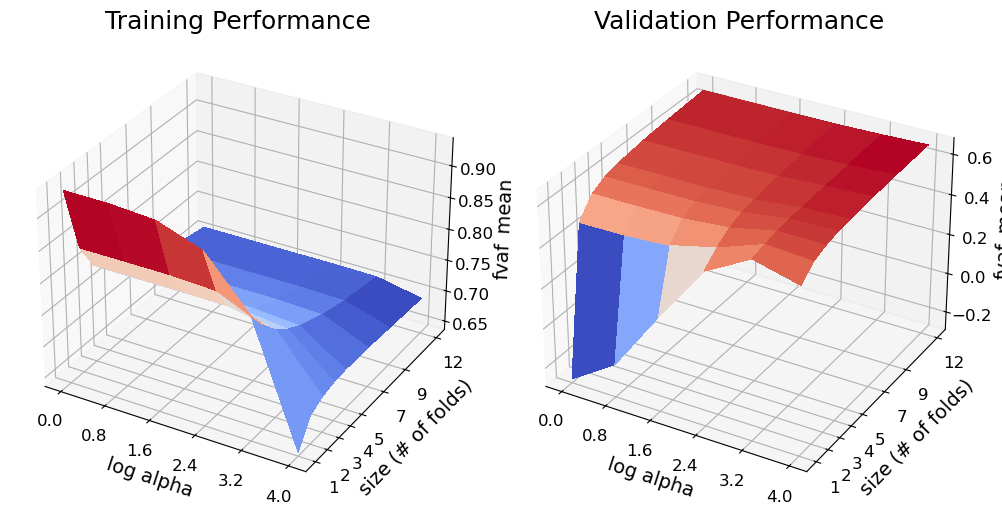

In [25]:
""" PROVIDED: EXECUTE CELL
RIDGE
Use plot_param_val_surface_RL() to plot the surface of the training
and validation set performance versus alpha and size,
"""
# Feel free to adjust these to understand the shape of the surface
# Elevation of the plot
elev = 30
# Angle the plot is viewed
angle = 300

# Plot
plot_param_val_surface_RL(crossval_ridge, crossval_ridge.opt_metric, 
                          list(ridge_alphas), elev=elev, angle=angle)
plt.show()

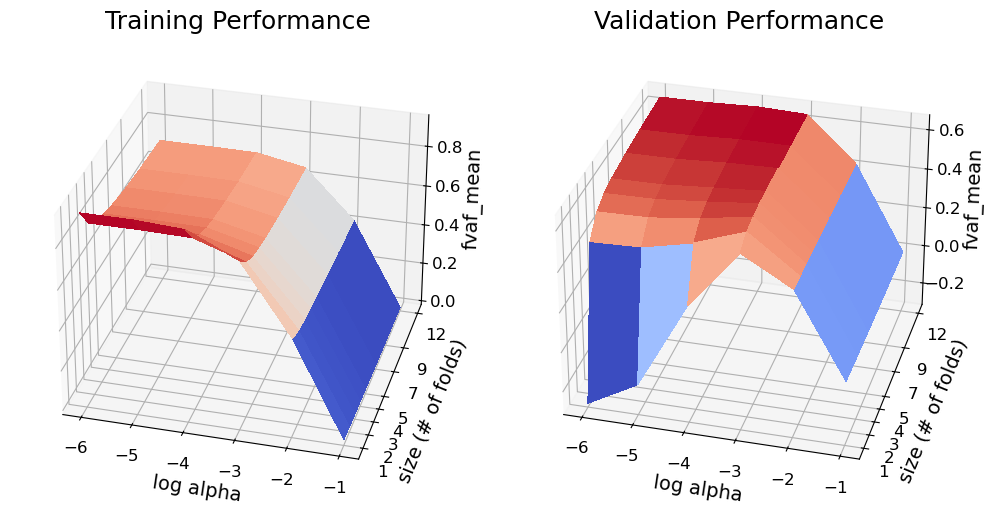

In [81]:
""" PROVIDED: EXECUTE CELL
LASSO

Use plot_param_val_surface_RL() to plot the surface of the training
and validation set performance versus alpha and size,
"""
# Feel free to adjust these to understand the shape of the surface
# Elevation of the plot
elev = 30
# Angle the plot is viewed
angle = 285

# Plot
plot_param_val_surface_RL(crossval_lasso, crossval_lasso.opt_metric, 
                          list(lasso_alphas), elev=elev, angle=angle)
plt.show()

# Reflection I

Give short answers to each of the following questions:

_Q1: Looking at the training and validation set performance surface plots for Ridge, which alphas gives the best performance for training set size of 12 folds?_

Alpha values 0 to 3.2 provide the highest performance for 12 folds on training set. Alpha values 0 to 4.0 show the best validation performance for 12 folds on test set.

_Q2: Looking at the training and validation set performance surface plots for Ridge, which alphas gives the best performance for training set size of 1 fold?_

Alpha values 0 to 0.8 provide the highest performance for 12 folds on training set. Alpha values 0.8 to 4.0 show the best validation performance for 12 folds on test set.


_Q3: For training set size 1 for Lasso, explain why the performance is monotonically decreasing with alpha, while validation set performance forms a different shape._

With only 1 fold (small dataset), the model struggles with generalization, and increasing alpha steadily reduces the model’s capacity to fit the data, leading to a monotonic decrease.The validation set performance reflects the balance between bias and variance. Moderate alpha values give the best performance by preventing overfitting while retaining predictive power, resulting in a non-monotonic curve with an optimal alpha.


# Best Parameter Sets

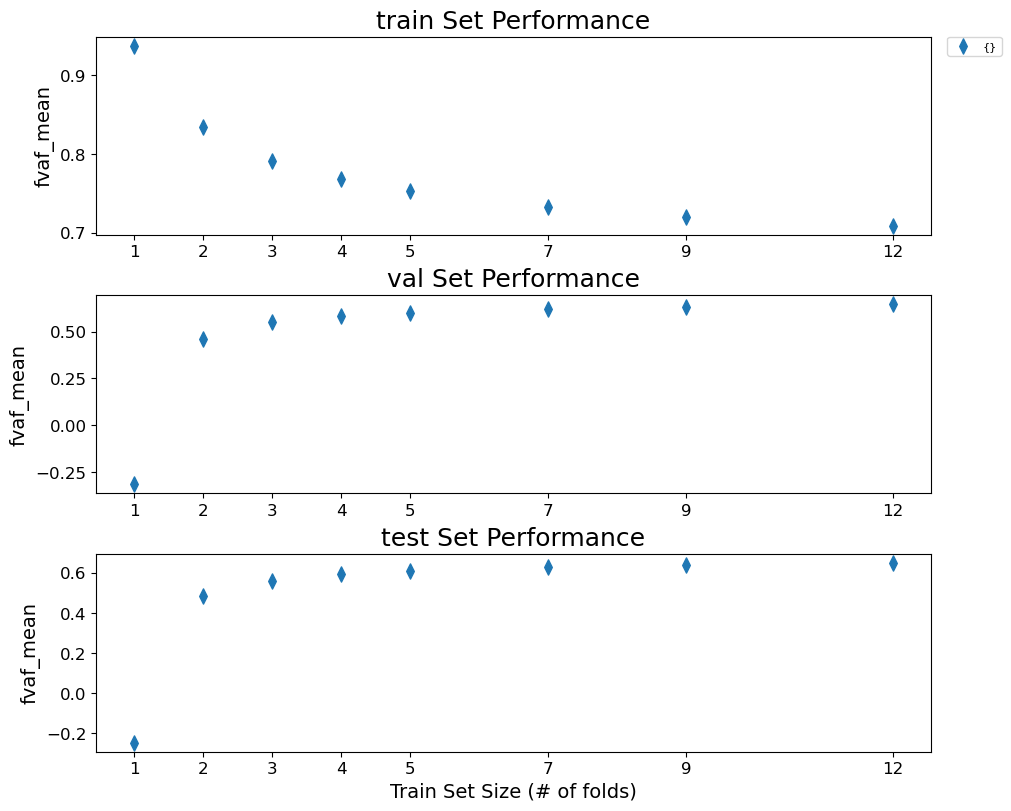

In [59]:
""" PROVIDED: EXECUTE CELL

LINEAR REGRESSION
Plot the mean (summary) train, validation and test set performance for 
the best hyperparameter set for each train size. Use plot_best_params_by_size()

"""
crossval_lnr.plot_best_params_by_size() 
plt.show()

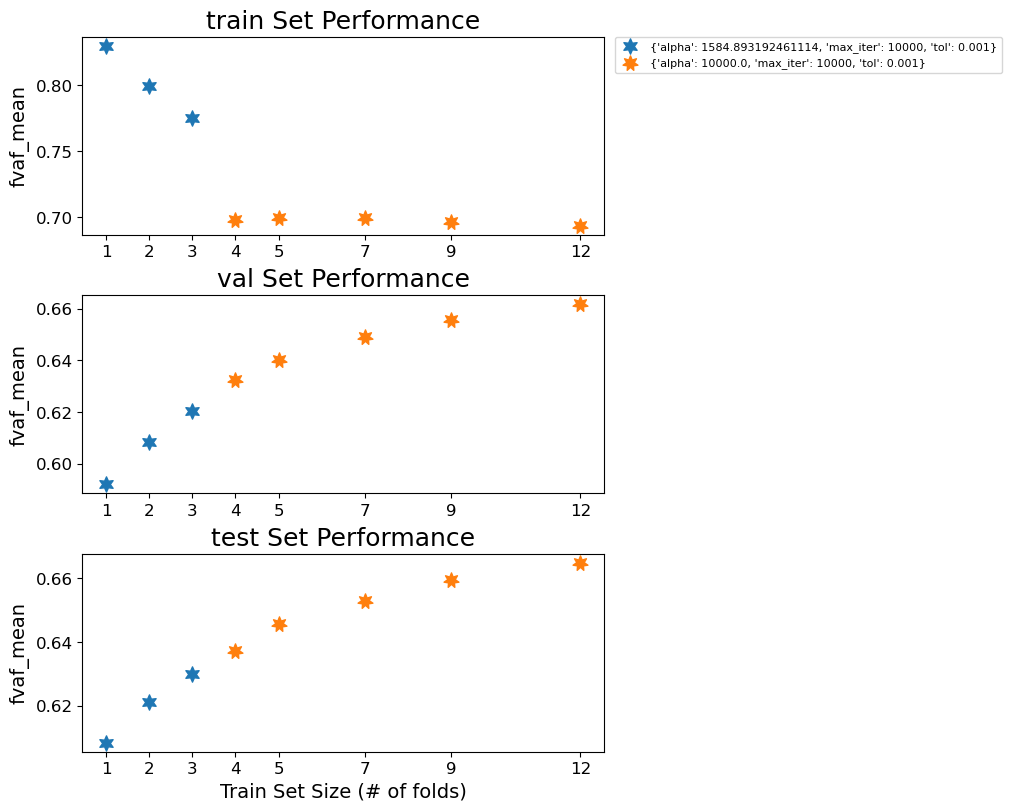

In [37]:
""" PROVIDED: EXECUTE CELL

RIDGE REGRESSION
Plot the mean (summary) train, validation and test set performance for 
the best hyperparameter set for each train size. Use plot_best_params_by_size()

"""

crossval_ridge.plot_best_params_by_size() 
plt.show()

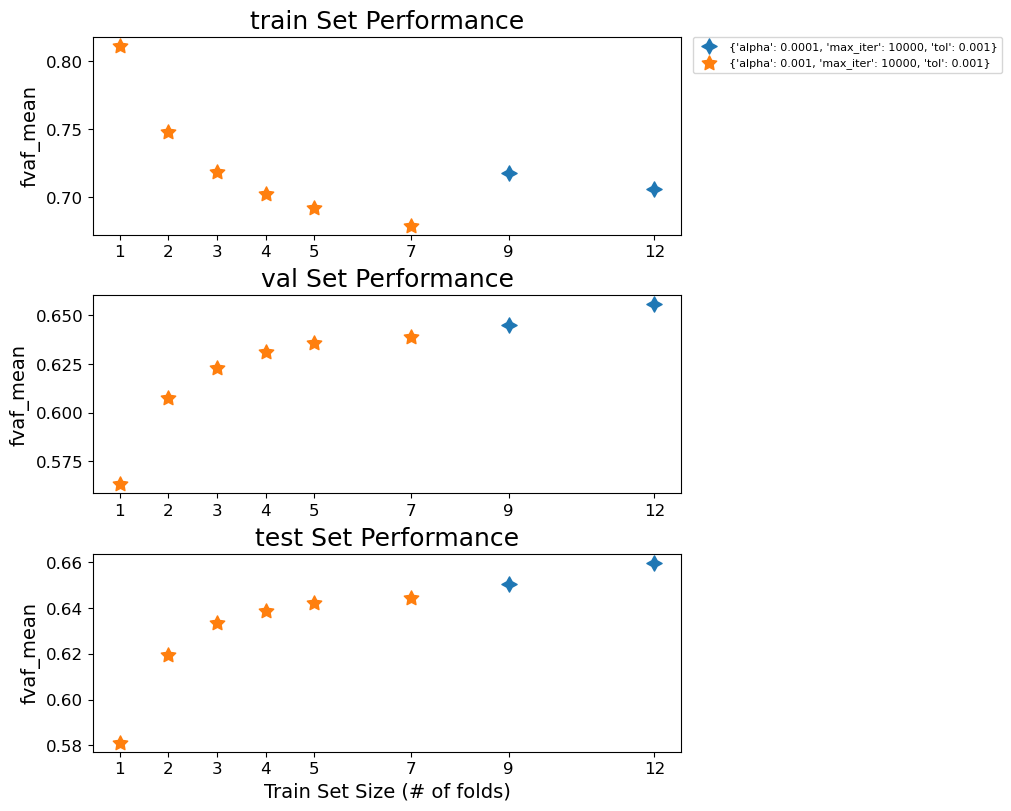

In [82]:
""" PROVIDED: EXECUTE CELL

LASSO REGRESSION
Plot the mean (summary) train, validation and test set performance for 
the best hyperparameter set for each train size. Use plot_best_params_by_size()

"""

crossval_lasso.plot_best_params_by_size() 
plt.show()

# Reflection II

Give short answers to the following questions:

_Q4: Explain why the cross-validation procedure has chosen exactly one hyperparameter set for LinearRegression_

Becuase Linear Regression doesnt have hyperparameters to tune.

_Q5: Explain the different hyper-parameter sets chosen for Lasso._

The Hyperparameters chosen for lasso is {'alpha': 0.0001, 'max iter': 10000, 'tol': 0.001} - blue and {'alpha': 0.001, 'max_iter': 10000, 'tol': 0.001 } - orange.
The alpha value of 0.0001 fold size 7 is performing well. For alpha value 0.001 fold size 12 is doing well. overall alpha 0.0001 is better cause it produces the highest test performance.

_Q6. For Ridge Regression, how do the mean validation and test set performance measures compare?  What can you conclude from this?_

The mean validation and test performance values are identical. Alpha value of 1584 is doing better initially but later alpha value 10000 is performing better.


 

<font style="font-size:0px">&#x55;&#x73;&#x65; &#x61; &#x6c;&#x6f;&#x74; &#x6f;&#x66; &#x6f;&#x66; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74;&#x73; &#x61;&#x6e;&#x64; &#x70;&#x72;&#x65;&#x66;&#x61;&#x63;&#x65; &#x65;&#x61;&#x63;&#x68; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74; &#x77;&#x69;&#x74;&#x68; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x6f;&#x75;&#x6e;&#x64; &#x73;&#x69;&#x67;&#x6e;

# &#x4d;&#x6f;&#x64;&#x65;&#x6c; &#x43;&#x6f;&#x6d;&#x70;&#x61;&#x72;&#x69;&#x73;&#x6f;&#x6e;&#x73;

In [83]:
""" PROVIDED: EXECUTE CELL
Obtain all the "best parameter" results for all the models
"""
def extract_test_stats(cv_list, metric, size_idx):
    '''
    :param cv_list: List of cross-validation grid search instances
    :param metric: Name of the metric that we are fetching from the report
    :param size_idx: Index of the training set size in the trainsizes variable.
    
    :return: List of test set performance structures.  One structure is 
            returned for each element in the cv_list
    '''
    
    out = []
    
    for cv in cv_list:
        # Fetch the results
        all_results = cv.results
        
        # Fetch best parameters
        best_params_idx = cv.best_param_inds[size_idx]
        
        # Test set performance for training size size_idx
        test_perf = all_results[best_params_idx]['results'][size_idx]['test'][metric]
        
        # Test set performance average across both shoulder and elbow
        test_perf_avg = np.mean(test_perf, axis=1)

        out.append(test_perf_avg)

    return out


&#x54;&#x4f;&#x44;&#x4f;: &#x45;&#x78;&#x65;&#x63;&#x75;&#x74;&#x65; &#x74;&#x68;&#x65; &#x61;&#x62;&#x6f;&#x76;&#x65; &#x66;&#x75;&#x6e;&#x63;&#x74;&#x69;&#x6f;&#x6e; &#x74;&#x6f; &#x65;&#x78;&#x74;&#x72;&#x61;&#x63;&#x74; &#x74;&#x68;&#x65; &#x69;&#x6e;&#x64;&#x69;&#x76;&#x69;&#x64;&#x75;&#x61;&#x6c; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x74;&#x65;&#x73;&#x74; &#x73;&#x74;&#x61;&#x74;&#x69;&#x73;&#x74;&#x69;&#x63;&#x73; (&#x4e;=&#x32;&#x30;) &#x66;&#x6f;&#x72; &#x61;&#x6c;&#x6c; &#x74;&#x68;&#x72;&#x65;&#x65; &#x63;&#x72;&#x6f;&#x73;&#x73;-&#x76;&#x61;&#x6c;&#x69;&#x64;&#x61;&#x74;&#x69;&#x6f;&#x6e; &#x72;&#x65;&#x73;&#x75;&#x6c;&#x74;&#x73;.
- &#x46;&#x56;&#x41;&#x46;

<font style="font-size:0px">&#x55;&#x73;&#x65; &#x61; &#x6c;&#x6f;&#x74; &#x6f;&#x66; &#x6f;&#x66; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74;&#x73; &#x61;&#x6e;&#x64; &#x70;&#x72;&#x65;&#x66;&#x61;&#x63;&#x65; &#x65;&#x61;&#x63;&#x68; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74; &#x77;&#x69;&#x74;&#x68; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x6f;&#x75;&#x6e;&#x64; &#x73;&#x69;&#x67;&#x6e; 

- &#x54;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74; &#x73;&#x69;&#x7a;&#x65; &#x6f;&#x66; &#x31; &#x66;&#x6f;&#x6c;&#x64;


In [84]:
metric = 'fvaf'
training_size_idx = 0

test_lnr, test_ridge, test_lasso = extract_test_stats(
    cv_list=[crossval_lnr, crossval_ridge, crossval_lasso],  # List of cross-validation objects
    metric=metric,  # Metric to extract (e.g., fvaf)
    size_idx=training_size_idx  # Training size index
)

# Display the extracted test statistics
print(f"Linear Regression Test Stats (N=20): {test_lnr}")
print(f"Ridge Regression Test Stats (N=20): {test_ridge}")
print(f"Lasso Regression Test Stats (N=20): {test_lasso}")

Linear Regression Test Stats (N=20): [-0.41234534 -1.00632667  0.16269128 -0.31511497 -0.43735045 -0.34836172
  0.01547    -1.67995956 -0.07798779  0.01680404 -0.65989077 -0.31993396
 -0.0387731  -0.23950516  0.22731464 -0.41272076  0.22419401  0.16921406
  0.37330435 -0.17267509]
Ridge Regression Test Stats (N=20): [0.52988599 0.68104363 0.66925529 0.71198014 0.55576948 0.51391795
 0.59861774 0.53313089 0.34274588 0.61658425 0.64240694 0.56587608
 0.62559575 0.66125977 0.65256019 0.6182431  0.57388989 0.6966874
 0.68832401 0.69041033]
Lasso Regression Test Stats (N=20): [0.53815048 0.681644   0.663459   0.70783325 0.50240054 0.49105351
 0.56327594 0.37646884 0.30013447 0.59673887 0.58185577 0.55706698
 0.63264217 0.62230603 0.65055994 0.55417406 0.57097517 0.69644463
 0.6822093  0.65272144]


 
## &#x54;&#x4f;&#x44;&#x4f;: &#x4c;&#x69;&#x6e;&#x65;&#x61;&#x72;&#x52;&#x65;&#x67;&#x72;&#x65;&#x73;&#x73;&#x69;&#x6f;&#x6e; &#x76;&#x73; &#x4c;&#x61;&#x73;&#x73;&#x6f;

&#x45;&#x78;&#x65;&#x63;&#x75;&#x74;&#x65; &#x74;&#x68;&#x65; &#x70;&#x61;&#x69;&#x72;&#x65;&#x64; &#x74;-&#x74;&#x65;&#x73;&#x74; &#x74;&#x6f; &#x64;&#x65;&#x74;&#x65;&#x72;&#x6d;&#x69;&#x6e;&#x65; &#x77;&#x68;&#x65;&#x74;&#x68;&#x65;&#x72; &#x74;&#x6f; &#x72;&#x65;&#x6a;&#x65;&#x63;&#x74; &#x74;&#x68;&#x65; &#x6e;&#x75;&#x6c;&#x6c; &#x68;&#x79;&#x70;&#x6f;&#x74;&#x68;&#x65;&#x73;&#x69;&#x73; 
(&#x69;.&#x65;. &#x48;&#x30;) &#x77;&#x69;&#x74;&#x68; &#x39;&#x35;% &#x63;&#x6f;&#x6e;&#x66;&#x69;&#x64;&#x65;&#x6e;&#x63;&#x65;. &#x48;&#x30; &#x69;&#x73; &#x74;&#x68;&#x61;&#x74; &#x74;&#x68;&#x65; &#x6d;&#x65;&#x61;&#x6e; &#x6f;&#x66; &#x74;&#x68;&#x65; &#x64;&#x69;&#x73;&#x74;&#x72;&#x69;&#x62;&#x75;&#x74;&#x69;&#x6f;&#x6e; &#x6f;&#x66; &#x74;&#x68;&#x65; 
&#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x63;&#x65;&#x73; &#x62;&#x65;&#x74;&#x77;&#x65;&#x65;&#x6e; &#x74;&#x65;&#x73;&#x74; &#x73;&#x63;&#x6f;&#x72;&#x65;&#x73; &#x66;&#x6f;&#x72; &#x74;&#x68;&#x65; &#x62;&#x65;&#x73;&#x74; &#x4c;&#x69;&#x6e;&#x65;&#x61;&#x72;&#x52;&#x65;&#x67;&#x72;&#x65;&#x73;&#x73;&#x69;&#x6f;&#x6e; &#x6d;&#x6f;&#x64;&#x65;&#x6c; &#x61;&#x6e;&#x64; &#x74;&#x68;&#x65; &#x62;&#x65;&#x73;&#x74; 
&#x4c;&#x61;&#x73;&#x73;&#x6f; &#x69;&#x73; &#x7a;&#x65;&#x72;&#x6f;.

- &#x52;&#x65;&#x6d;&#x65;&#x6d;&#x62;&#x65;&#x72; &#x74;&#x68;&#x61;&#x74; &#x74;&#x68;&#x69;&#x73; &#x69;&#x73; &#x66;&#x6f;&#x72; &#x74;&#x72;&#x61;&#x69;&#x6e;&#x69;&#x6e;&#x67; &#x73;&#x65;&#x74; &#x73;&#x69;&#x7a;&#x65; &#x6f;&#x66; &#x31;
- &#x44;&#x69;&#x73;&#x70;&#x6c;&#x61;&#x79; &#x74;&#x68;&#x65; &#x74;-&#x73;&#x74;&#x61;&#x74;&#x69;&#x73;&#x74;&#x69;&#x63;, &#x74;&#x68;&#x65; &#x70;-&#x76;&#x61;&#x6c;&#x75;&#x65;, &#x61;&#x6e;&#x64; &#x74;&#x68;&#x65; &#x6d;&#x65;&#x61;&#x6e; &#x6f;&#x66; 
&#x74;&#x68;&#x65; &#x70;&#x61;&#x69;&#x72;&#x77;&#x69;&#x73;&#x65; &#x64;&#x69;&#x66;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x63;&#x65;&#x73; 

<font style="font-size:0px">&#x55;&#x73;&#x65; &#x61; &#x6c;&#x6f;&#x74; &#x6f;&#x66; &#x6f;&#x66; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74;&#x73; &#x61;&#x6e;&#x64; &#x70;&#x72;&#x65;&#x66;&#x61;&#x63;&#x65; &#x65;&#x61;&#x63;&#x68; &#x63;&#x6f;&#x6d;&#x6d;&#x65;&#x6e;&#x74; &#x77;&#x69;&#x74;&#x68; &#x64;&#x6f;&#x75;&#x62;&#x6c;&#x65; &#x70;&#x6f;&#x75;&#x6e;&#x64; &#x73;&#x69;&#x67;&#x6e;

- &#x55;&#x73;&#x65; &#x73;&#x74;&#x61;&#x74;&#x73;.&#x74;&#x74;&#x65;&#x73;&#x74;_&#x72;&#x65;&#x6c;(). &#x53;&#x65;&#x65; &#x74;&#x68;&#x65; &#x41;&#x50;&#x49; &#x72;&#x65;&#x66;&#x65;&#x72;&#x65;&#x6e;&#x63;&#x65; &#x61;&#x62;&#x6f;&#x76;&#x65;.


In [85]:
from scipy.stats import ttest_rel

# Compute the pairwise differences
differences = test_lnr - test_lasso

# Perform the paired t-test
t_stat, p_value = ttest_rel(test_lnr, test_lasso)

# Compute the mean of the pairwise differences
mean_diff = np.mean(differences)

# Display the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Mean of the Pairwise Differences: {mean_diff:.4f}")

# Check if we reject the null hypothesis at 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: -8.3458
P-value: 8.8881e-08
Mean of the Pairwise Differences: -0.8277
Reject the null hypothesis: There is a significant difference.


## TODO: LinearRegression vs Ridge 

Perform the same sequence of operations to compare Linear Regression with Ridge Regression

In [86]:
# Compute the pairwise differences
differences = test_lnr - test_ridge

# Perform the paired t-test
t_stat, p_value = ttest_rel(test_lnr, test_ridge)

# Compute the mean of the pairwise differences
mean_diff = np.mean(differences)

# Display the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Mean of the Pairwise Differences: {mean_diff:.4f}")

# Check if we reject the null hypothesis at 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")

T-statistic: -8.1796
P-value: 1.2033e-07
Mean of the Pairwise Differences: -0.8550
Reject the null hypothesis: There is a significant difference.


## TODO: Lasso vs Ridge

Perform the same sequence of operations to compare Lasso Regression with Ridge Regression

In [87]:
# Compute the pairwise differences
differences = test_lasso - test_ridge

# Perform the paired t-test
t_stat, p_value = ttest_rel(test_lasso, test_ridge)

# Compute the mean of the pairwise differences
mean_diff = np.mean(differences)

# Display the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Mean of the Pairwise Differences: {mean_diff:.4f}")

# Check if we reject the null hypothesis at 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")

T-statistic: -3.2114
P-value: 4.5955e-03
Mean of the Pairwise Differences: -0.0273
Reject the null hypothesis: There is a significant difference.


## Training Set Size 12

Perform the same sequence of operations for training set size 12


In [88]:
metric = 'fvaf'
training_size_idx = len(trainsizes)-1

test_lnr, test_ridge, test_lasso = extract_test_stats(
    cv_list=[crossval_lnr, crossval_ridge, crossval_lasso],  # List of cross-validation objects
    metric=metric,  # Metric to extract (e.g., fvaf)
    size_idx=training_size_idx  # Training size index
)

# Display the extracted test statistics
print(f"Linear Regression Test Stats (N=20): {test_lnr}")
print(f"Ridge Regression Test Stats (N=20): {test_ridge}")
print(f"Lasso Regression Test Stats (N=20): {test_lasso}")
    

Linear Regression Test Stats (N=20): [0.61268107 0.66348716 0.65015532 0.70457514 0.60914631 0.57945905
 0.6209777  0.66168215 0.45141212 0.68350133 0.68673341 0.64804018
 0.71270293 0.67744867 0.67457835 0.72114606 0.62403321 0.70858771
 0.67905865 0.64431916]
Ridge Regression Test Stats (N=20): [0.63162665 0.72020634 0.70924958 0.74872684 0.63569063 0.57940823
 0.61536991 0.65314093 0.42650668 0.66767987 0.67979079 0.62782173
 0.71161977 0.69830337 0.68970852 0.73019428 0.62933765 0.72608376
 0.71355458 0.70441277]
Lasso Regression Test Stats (N=20): [0.62656088 0.68724863 0.67261286 0.71937978 0.62189218 0.58577065
 0.62063362 0.6670631  0.44863507 0.67958132 0.68985834 0.64619039
 0.72132807 0.68950468 0.68118412 0.7264817  0.62891216 0.71834271
 0.69515543 0.67038914]


In [89]:
# Linear VS LASSO

from scipy.stats import ttest_rel

# Compute the pairwise differences
differences = test_lnr - test_lasso

# Perform the paired t-test
t_stat, p_value = ttest_rel(test_lnr, test_lasso)

# Compute the mean of the pairwise differences
mean_diff = np.mean(differences)

# Display the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Mean of the Pairwise Differences: {mean_diff:.4f}")

# Check if we reject the null hypothesis at 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")


T-statistic: -4.7275
P-value: 1.4656e-04
Mean of the Pairwise Differences: -0.0091
Reject the null hypothesis: There is a significant difference.


In [90]:
# Linear VS Ridge

# Compute the pairwise differences
differences = test_lnr - test_ridge

# Perform the paired t-test
t_stat, p_value = ttest_rel(test_lnr, test_ridge)

# Compute the mean of the pairwise differences
mean_diff = np.mean(differences)

# Display the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Mean of the Pairwise Differences: {mean_diff:.4f}")

# Check if we reject the null hypothesis at 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")

T-statistic: -2.4354
P-value: 2.4900e-02
Mean of the Pairwise Differences: -0.0142
Reject the null hypothesis: There is a significant difference.


In [91]:
# LASSO VS Ridge

# Compute the pairwise differences
differences = test_lasso - test_ridge

# Perform the paired t-test
t_stat, p_value = ttest_rel(test_lasso, test_ridge)

# Compute the mean of the pairwise differences
mean_diff = np.mean(differences)

# Display the results
print(f"T-statistic: {t_stat:.4f}")
print(f"P-value: {p_value:.4e}")
print(f"Mean of the Pairwise Differences: {mean_diff:.4f}")

# Check if we reject the null hypothesis at 95% confidence
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis: There is a significant difference.")
else:
    print("Fail to reject the null hypothesis: No significant difference.")

T-statistic: -1.2656
P-value: 2.2094e-01
Mean of the Pairwise Differences: -0.0051
Fail to reject the null hypothesis: No significant difference.


# Reflection, III

Please give short answers to the following questions.
* You may ignore issues of multiple comparisons for this analysis
* Remember to report p-values as "p < SOME_VALUE" (it is not technically equal the way we are asking the significance question)
* When you are reporting p-values, you may always **round them up** to make the values shorter.  For example, you may transform p < .003911232 into p < .004.  However, be careful not to round across the critical alpha value.

_Q7: For training set size of 1, is there a statistically significant "best" model among the three?_

For training set size of 1, there is a statistically significant "best" model among the three.

Ridge regression is the better model, because:
It shows statistically significantly better performance compared to Lasso.
The mean difference is negative, meaning Ridge achieves a higher fvaf (on average) than Lasso.


_Q8: For training set size of 12, is there a statistically significant "best" model among the three?_

For training set size of 1, there is no statistically significant "best" model among the three.


_Q9: For training set size of 12, is there a meaningfull difference between Ridge and LinearRegression?_

For training set size of 12, there is a meaningfull difference between Ridge and LinearRegression.

Ridge regression is the better model, because:
It shows statistically significantly better performance compared to Lasso.
The mean difference is negative, meaning Ridge achieves a higher fvaf (on average) than Linear.




